# Building micrograd.

Based on https://github.com/Anri-Lombard/micrograd

Micrograd is light weight implementation of a deep learning library for learning purposes.

In [12]:
# Generic imports.
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Derivatives.
The first concept to understand is the derivative thats why we are going to create a function an calculate it derivate using the ecuation.
  
 f(x + h) - f(x))/h

A derivative, represents the rate at which a function changes at any given point. It's used to find out how a quantity changes in response to changes in another quantity.

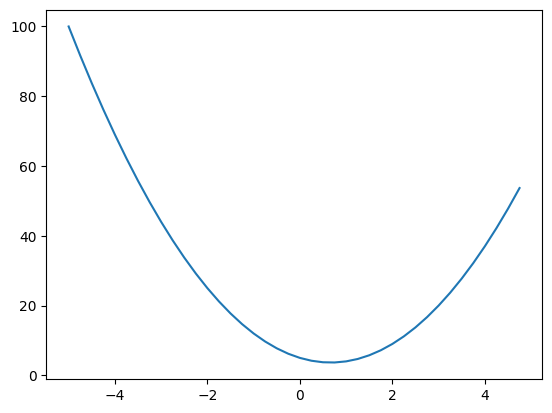

In [ ]:
#cuadratic function to
def f(x):
  return 3*x**2-4*x+5

# arange generates an incremental sequence. from, to, increment.
# since f(x) is a cuadratic function this will give us a parabola.
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

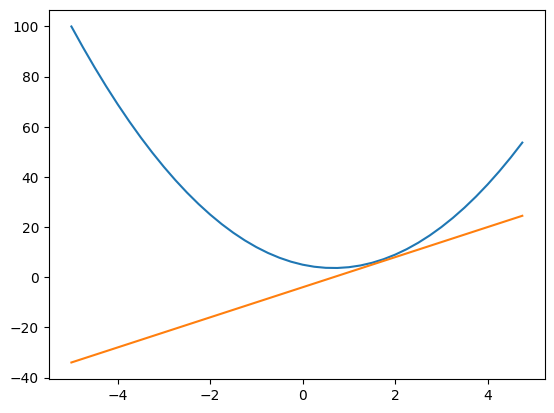

In [ ]:
# How much y changes if we change x by a tiny amount h.
h = 0.001
x = -2.0

# Derivate ecuation.
y_prime = (f(xs + h) - f(xs))/h
plt.plot(xs, ys)
plt.plot(xs, y_prime)
plt.show()

# Derivative with multiple variables.

On this section we will be comparing the slopes but with respect to each function input,

what it is the slope if we increate the value of a a litte bit?

In [ ]:
h = 0.0001

#inputs
a = 2
b = -3.0
c = 10

d1 = a*b+c
a += h
d2 = a*b+c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


# The class value

This class is responsible to encapsulate the different operations that an scalar value can have and store it along with the parent value object, and with this object we will be able to build a computational graph.

In [13]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [5]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

# Visualizing the entire mathematical expression graph

Since the Value Object contains all the informacion of the parents who generated that new value we can build a set of parent -> child relation using the trace function, build the graph and display it using draw_dot

In [6]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


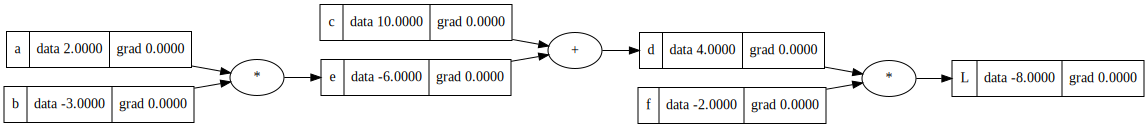

In [7]:
draw_dot(L)

# Applying Backpropagation manually.

The way this algorithm works is by calculating all the derivatives with respect to an output L.

What it tries to measure is the rate of change with respect to the value contained in the nodes.

These gradients will then be used to adjust the weights of the neural network, so after that, the gradients are recalculated in an iterative process until the output matches the expected result.


### Derivate chain rule

This is used to calculate the derivative of a composite function. Therefore, it is fundamental for deep learning since we need to calculate all the derivatives passing through all the nodes until the output.

Chain rule
h(x) = f(g(x))
h'(x) = f'(g(x))g'(x)

As put by George F. Simmons: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

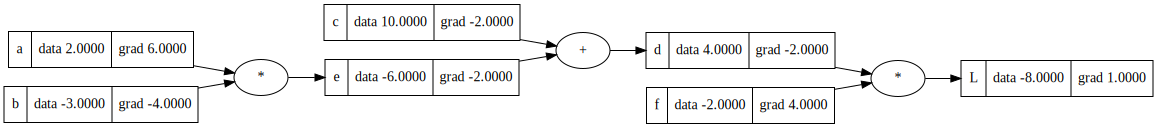

In [8]:
# applying backpropagation manually

h = 0.001

# derivate of L with respect to L is 1.0
L.grad = ((L.data + h) - L.data) / h

# dL/dd. L = d * f
d.grad = (d.data * f.data + h * f.data - d.data * f.data) / h

# dL/df. L = d * f
f.grad = (d.data * f.data + h * d.data - d.data * f.data) / h

# Applying chain rule

# In this case we need to apply the derivate chain rule because we need to find how e affects L trough d.
# dL/dc = ??

## First we calculate the local derivate/gradient
local_grad_e =  (((e.data + h) + c.data) - (e.data + c.data)) / h
##Apply chain rule to calculate final gradient.
e.grad = local_grad_e * d.grad

local_grad_c =  (((c.data + h) + e.data) - (e.data + c.data)) / h
##Apply chain rule to calculate final gradient.
c.grad = local_grad_c * d.grad

# NOTICE : the sum node is only propagating the signal.

## Apply local gradient to dL/db e = b * a
# (b + h) * a - (b * a) / h
local_grad_b = (b.data * a.data + h *  a.data - b.data * a.data) / h
b.grad = local_grad_b * e.grad

local_grad_a = (a.data * b.data + h * b.data - a.data * b.data) / h
a.grad = local_grad_a * e.grad

draw_dot(L)

# Forward pass

# Perceptron
https://cs231n.github.io/assets/nn1/neuron_model.jpeg




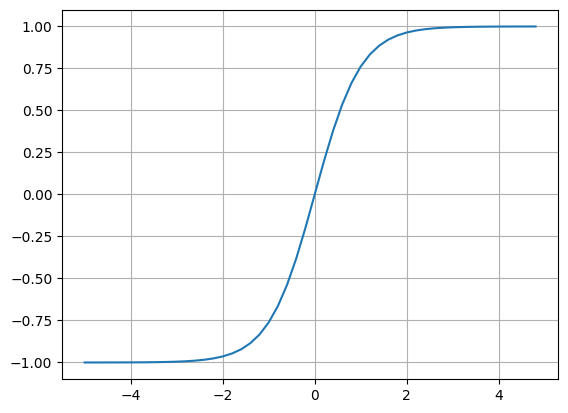

In [9]:
# activation function
plt.plot(np.arange(-5, 5,0.2),  np.tanh(np.arange(-5, 5,0.2)))
plt.grid();

In [10]:
# small perceptron

x1 = Value(2.0, label='x1')
x2 = Value(2.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')

# Topological sort

Topological Sort is a way of ordering the elements of a directed graph so that all dependencies are taken into account. This means that for every directed edge from node A to node B, node A comes before node B in the ordering. This is needed for backpropagation, because signals need to be propagated in a specific order to ensure accuracy.

In [14]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [21]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.9041873352349885)

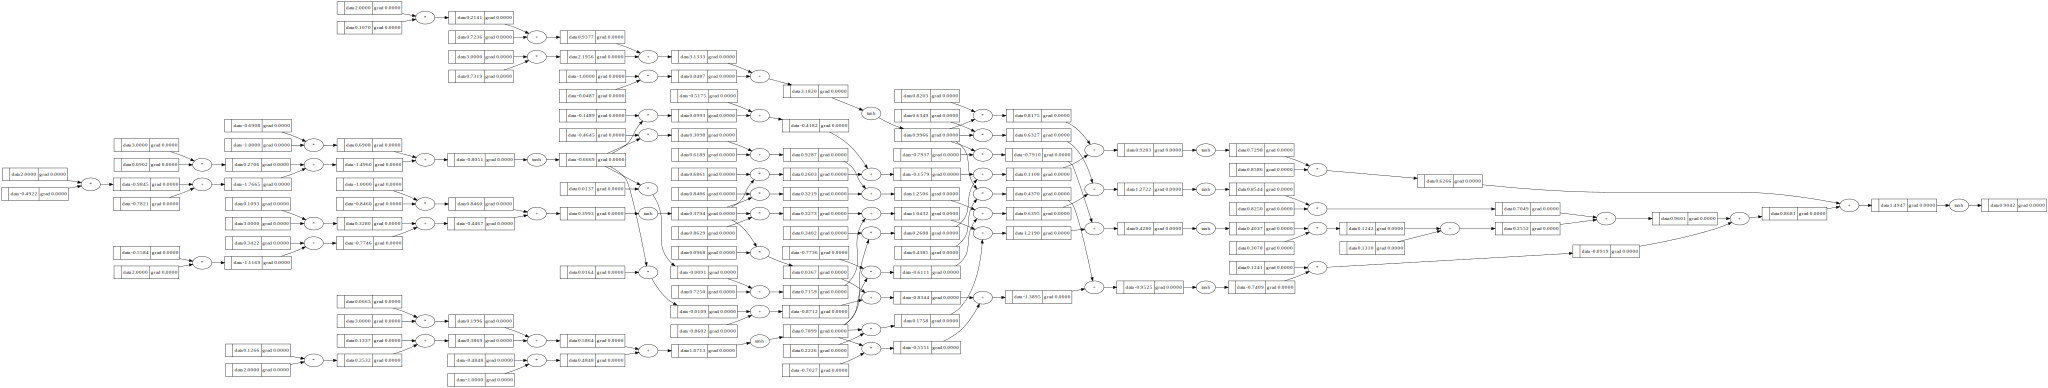

In [22]:
draw_dot(n(x))

In [23]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [26]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, f"Loss : {loss.data}")

0 Loss : 0.02348535704430603
1 Loss : 0.022204700480248005
2 Loss : 0.0210528873907711
3 Loss : 0.020011554624994266
4 Loss : 0.019065656764975018
5 Loss : 0.018202751074702532
6 Loss : 0.017412459417672926
7 Loss : 0.016686058135883614
8 Loss : 0.016016161787357125
9 Loss : 0.01539647663505548
10 Loss : 0.01482160659887991
11 Loss : 0.01428689910727567
12 Loss : 0.013788321606238562
13 Loss : 0.013322361849412833
14 Loss : 0.012885946799180446
15 Loss : 0.01247637621327223
16 Loss : 0.012091267909090635
17 Loss : 0.011728512381298146
18 Loss : 0.011386234961876587
19 Loss : 0.011062764101357325


In [27]:
ypred

[Value(data=0.9503680463184021),
 Value(data=-0.964420685240921),
 Value(data=-0.9310342863495694),
 Value(data=0.949233121259366)]